<a href="https://colab.research.google.com/github/fionaz12308-dot/amazon-beauty-sentiment-analysis/blob/main/%E2%80%9CAmazon-beauty-sentiment-analysis%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook will take the Amazon Review Data 2023 and use one of the largest product categories "Beauty_and_Personal_Care" as an example to show how to load and process the data before conducting any analysis. More information is available from https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023 as well as https://amazon-reviews-2023.github.io/main.html

# **Analysing Amazon review data for Beauty_and_Personal_Care**

## Project Overview
This project analyzes customer reviews from Amazon's "Beauty and Personal Care" category to uncover the factors influencing consumer sentiment. Using Natural Language Processing (NLP) and Machine Learning techniques, we aim to:
1.  **Compare model performance** between Logistic Regression, Random Forest, and VADER for sentiment classification.
2.  **Investigate the impact** of product price, brand, and color on review sentiment.
3.  **Identify key words** most associated with positive and negative experiences.

The insights derived can inform business strategies in product development, marketing, and customer experience management.

## 目录导航
1.  **环境设置与数据加载**
    *   安装并导入依赖库
    *   从HuggingFace加载评论数据集 (`Beauty_and_Personal_Care`)
    *   从HuggingFace加载产品元数据集 (`Meta-data`)

2.  **数据预处理与特征工程**
    *   数据清洗：处理缺失值、提取`品牌`与`颜色`特征
    *   数据合并：基于`parent_asin`合并评论与元数据表
    *   数据过滤：保留`verified_purchase`（已验证购买）的评论
    *   定义情感标签：将1-2星评为负面(0)，4-5星评为正面(1)，剔除3星中性评论

3.  **探索性数据分析 (EDA)**
    *   评分分布分析 - 揭示“J型分布”与类别不平衡问题
    *   产品价格分布分析
    *   核心品牌占比分析 (Top 10 Brands)

4.  **文本预处理与建模准备**
    *   文本清洗：去除特殊字符、停用词、标准化文本
    *   特征向量化：使用TF-IDF创建特征矩阵
    *   处理类别不平衡：应用SMOTE算法生成合成样本

5.  **模型训练、评估与对比**
    *   数据集划分：80%训练集，20%测试集
    *   机器学习模型训练与调优
        Logistic Regression
        Random Forest
    *   基于词典的模型评估：VADER Sentiment Analysis
    *   模型性能全面对比：准确率、精准率、召回率、F1-Score、AUC

6.  **深度洞察与可视化**
    *   品牌情感分析：不同品牌的情感倾向差异
    *   价格情感关系：价格区间如何影响情感得分
    *   颜色负面情感排名：定位问题最突出的产品颜色
    *   交互分析：品牌在不同价格区间的情感表现
    *   关键词挖掘：生成正面与负面评论词云


In [ ]:
!pip install datasets
import pandas as pd

import datasets
datasets.logging.set_verbosity_error()

from datasets import load_dataset

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
nltk.download(['vader_lexicon', 'stopwords'])


import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score)
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import TruncatedSVD  # 新增降维

# 补充下载必要资源
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1.&nbsp;Next load the review dataset from HuggingFace for "Beauty_and_Personal_Care" <font color=red>(it will take about 16 mins).</font>

In [ ]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Beauty_and_Personal_Care", trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

Beauty_and_Personal_Care.jsonl:   0%|          | 0.00/11.0G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    full: Dataset({
        features: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase'],
        num_rows: 23911390
    })
})

In [ ]:
dataset['full'][0]

{'rating': 1.0,
 'title': 'Gasoline!! Seriously reeks of gasoline!',
 'text': 'Opened the package & instant migraine. I cannot believe the stench.  I have purchased other packages that did not smell at all so I do not know if these were a damaged shipment or damaged during packaging or what, but the minute I opened the Amazon package I smelled it before I even opened the Terra Tattoos package. I couldn’t believe it. Then I find that the pink inks from the back have smeared all over the fronts of the tattoos. Yes, you eventually take the clear part off to apply the tattoo, but I always lay it down with the clear covering first to line it up & I didn’t want to risk the pink ink transferring to my art projects so it’s going back. I’ll update the review when Amazon sends my replacement. I’m upset because now my resin is here & I don’t have the tattoos to do my project, but I’m more mad about the fact that I have a massive migraine because of the gasoline fumes that lingered.  I believe the

## 2.&nbsp;Next load the meta datafile from HuggingFace for "Beauty_and_Personal_Care" <font color=red>(it will take about 21 mins).</font>

In [ ]:
metaset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Beauty_and_Personal_Care", split="full", trust_remote_code=True)

meta_Beauty_and_Personal_Care.jsonl:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

In [ ]:
metaset

Dataset({
    features: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
    num_rows: 1028914
})

In [ ]:
# Again check an entry
metaset[0]

{'main_category': 'All Beauty',
 'title': 'Shiyeen 10 Colors Hair Chalk for Girls Gift, Kids Temporary Bright Hair Color, Halloween Hair Chalk Comb Birthday Gift for Girls Of Ages 4 5 6 7 8 9 10+ Washable Non-Toxic for Kids Hair Dyeing Cosplay on Birthday Easter Party',
 'average_rating': 3.9,
 'rating_number': 57,
 'features': ['🌼[MEET YOUR HAIR COLOR NEEDS] Bright color, high-quality hair chalk. The comb applicators make it quick and easy to put dazzling colors into your hair. Your hair will be supple and natural, not stiff and sticky.',
  '🌼[Shiyeen COLORFUL HAIR CHALK COMBS SET] Contains White, purple, blue, orange, pink, red, cyan, green, brown, Rose ,10 bright colors, Disposable gloves, hair dye shawl.',
  '🌼[NON-TOXIC & EASY TO WASH] The hair chalk is non-allergenic , non-toxic and water-soluble and environmentally friendly ; apply it to hair evenly from top to bottom and washes out with ordinary shampoo and water.',
  '🌼[USING SIMPLE] The hair chalks are perfect for going wild!

## 3. data preprocessing
### (1) Select variables + Merge tables based on 'parent_asin'
### (2) Cleaning
### (3) Transformation

In [ ]:
selected_columns = ['parent_asin', 'price', 'categories', 'details']
meta_subset = metaset.select_columns(selected_columns)

In [ ]:
meta_subset

Dataset({
    features: ['parent_asin', 'price', 'categories', 'details'],
    num_rows: 1028914
})

In [ ]:
meta_subset[1]

{'parent_asin': 'B0BWJGQ32Y',
 'price': '45.65',
 'categories': ['Beauty & Personal Care',
  'Hair Care',
  'Hair Extensions, Wigs & Accessories',
  'Wigs'],
 'details': '{"Color": "13x4 Bob Wigs", "Material": "Human", "Hair Type": "Straight", "Brand": "Ebbfurln", "Age Range (Description)": "Adult", "Package Dimensions": "7.8 x 6.3 x 2.9 inches; 5.61 Ounces", "UPC": "735530223338", "Manufacturer": "Ebbfurln"}'}

In [ ]:
type('price')

str

In [ ]:
# 所需要的Color和Brand两个变量被包含在details列中，需要将其提取出来形成两个单独的列

# 解析 details 并提取 Brand 和 Color
import json
def extract_details(example):
    try:
        details_dict = json.loads(example['details'])
    except json.JSONDecodeError:
        details_dict = {}

    color_str = details_dict.get("Color", "")
    if color_str:
        colors = [c.strip() for c in color_str.split(",")]
    else:
        colors = ["Unknown"]  # 缺失时填充默认值

    brand = details_dict.get("Brand")
    if not brand or brand.strip().lower() == "unknown":
        return None  # 标记为待删除行
    else:
        return {"brand": brand.strip(), "color": colors}

In [ ]:
meta_subset = meta_subset.map(extract_details)

Map:   0%|          | 0/380597 [00:00<?, ? examples/s]

In [ ]:
meta_subset = meta_subset.filter(lambda x: x is not None)

Filter:   0%|          | 0/286531 [00:00<?, ? examples/s]

In [ ]:

# 移除原始 details 字段
final_columns = ["parent_asin", "price", "categories", "brand", "color"]
meta_clean = meta_subset.remove_columns(["details"])

In [ ]:
print(meta_clean)

Dataset({
    features: ['parent_asin', 'price', 'categories', 'brand', 'color'],
    num_rows: 286531
})


In [ ]:
meta_clean[1]

{'parent_asin': 'B0BM8WLSXF',
 'price': '24.99',
 'categories': ['Beauty & Personal Care',
  'Hair Care',
  'Hair Cutting Tools',
  'Hair Clippers & Accessories',
  'Clipper Combs & Guides'],
 'brand': 'CR8GR8',
 'color': ['Gray']}

In [ ]:
from collections import Counter

# 清洗品牌名称（统一格式）
def clean_brand(example):
    if example["brand"]:
        # 去除首尾空格 + 首字母大写 + 清除特殊符号
        brand = example["brand"].strip().title().replace("®", "").replace("™", "")
        return {"brand": brand}
    else:
        return {"brand": None}

# 先清洗数据
meta_clean = meta_clean.map(clean_brand)

# 统计品牌频率（基于清洗后的数据）
brand_counter = Counter(
    example["brand"]
    for example in meta_clean
    if example["brand"] is not None
)

# 获取Top5品牌列表
top5_brands = [brand for brand, _ in brand_counter.most_common(10)]
print("目标品牌:", top5_brands)

Map:   0%|          | 0/286531 [00:00<?, ? examples/s]

目标品牌: ['Bath & Body Works', 'Generic', 'Revlon', 'L’Oréal Paris', 'Sally Hansen', 'Clinique', 'Nyx Professional Makeup', 'Maybelline New York', 'Covergirl', 'Kiss']


In [ ]:
def batch_filter_top5(batch):
    # 清洗后的品牌名称匹配（大小写敏感）
    return [brand in top5_brands for brand in batch["brand"]]

# 应用过滤
filtered_metaset = meta_clean.filter(
    batch_filter_top5,
    batched=True,
    batch_size=1000  # 根据Colab内存调整
)

Filter:   0%|          | 0/286531 [00:00<?, ? examples/s]

In [ ]:
# 获取实际保留的品牌
remaining_brands = set(filtered_metaset.unique("brand"))

# 精准断言（处理大小写问题）
assert remaining_brands.issubset(top5_brands), f"发现异常品牌: {remaining_brands - set(top5_brands)}"

# 打印结果
print(f"\n原始数据量: {len(meta_clean)}")
print(f"过滤后数据量: {len(filtered_metaset)}")
print("保留的品牌:", remaining_brands)

Flattening the indices:   0%|          | 0/11239 [00:00<?, ? examples/s]


原始数据量: 286531
过滤后数据量: 11239
保留的品牌: {'Revlon', 'Kiss', 'Clinique', 'Generic', 'Bath & Body Works', 'L’Oréal Paris', 'Covergirl', 'Sally Hansen', 'Nyx Professional Makeup', 'Maybelline New York'}


In [ ]:
filtered_metaset

Dataset({
    features: ['parent_asin', 'price', 'categories', 'brand', 'color'],
    num_rows: 11239
})

In [ ]:
filtered_metaset[0]

{'parent_asin': 'B00N54K1UM',
 'price': '5.18',
 'categories': ['Beauty & Personal Care', 'Makeup', 'Lips', 'Lipstick'],
 'brand': 'Revlon',
 'color': ['Unknown']}

In [ ]:
#myMetaSubASIN = myMetaSub['parent_asin']
myMetaSubASIN=filtered_metaset['parent_asin']

In [ ]:
myMetaSubASIN = set(myMetaSubASIN) # 将列表转换为集合

In [ ]:
mySubset = dataset.filter(lambda example: example['parent_asin'] in myMetaSubASIN)

Filter:   0%|          | 0/23911390 [00:00<?, ? examples/s]

In [ ]:
# Check how many reviews we have
len(mySubset['full'])

759918

In [ ]:
# Now convert both subsets to pandas dataframes
myReviewSubDF = pd.DataFrame(mySubset['full'])
myMetaSubDF = pd.DataFrame(filtered_metaset )

In [ ]:
myDF = myReviewSubDF.merge(myMetaSubDF, on='parent_asin', how='left')

In [ ]:
len(myDF)#759918

759918

In [ ]:
myDF.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,price,categories,brand,color
0,5.0,Wondeful color,Love the product!!!!,[],B00BKH9HRE,B0BJLPRXZ6,AEAUZK2OLWXD75AWJOCCGGCL3H2A,1563732209627,0,True,4.97,"[Beauty & Personal Care, Makeup, Lips, Lip Glo...",Nyx Professional Makeup,[22 Devil's Food Cake]
1,5.0,Great brows,Last all day,[],B07GXC7TYQ,B07HFKYDT5,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,1560013407595,0,True,9.39,"[Beauty & Personal Care, Makeup, Eyes, Eyebrow...",Maybelline New York,[Medium Brown]
2,5.0,Five Stars,loved it.,[],B01IAECEF6,B000HZYGBW,AFWHJ6O3PV4JC7PVOJH6CPULO2KQ,1524767255656,1,True,29.99,"[Beauty & Personal Care, Makeup, Lips, Lipstick]",Revlon,[420 Blushed]
3,4.0,It’s nice,I really like this lipstick. It is not overpow...,"[{'attachment_type': 'IMAGE', 'large_image_url...",B006GQTZ8A,B01NH0GYC1,AHXBL3QDWZGJYH7A5CMPFNUPMF7Q,1594124969716,2,True,15.99,"[Beauty & Personal Care, Makeup, Lips, Lipstick]",Revlon,[Sugar Plum]
4,5.0,"Great price, works well",i think these work really well.,[],B0000532A2,B0000532A2,AHXBL3QDWZGJYH7A5CMPFNUPMF7Q,1481251902000,0,True,5.6,"[Beauty & Personal Care, Shave & Hair Removal,...",Revlon,[Multicolor]


In [ ]:
# myDF 是已加载的 DataFrame
# 打印原始 DataFrame 的前几行
print("原始 DataFrame:")
print(myDF.head())


原始 DataFrame:
   rating                    title  \
0     5.0           Wondeful color   
1     5.0              Great brows   
2     5.0               Five Stars   
3     4.0                It’s nice   
4     5.0  Great price, works well   

                                                text  \
0                               Love the product!!!!   
1                                       Last all day   
2                                          loved it.   
3  I really like this lipstick. It is not overpow...   
4                    i think these work really well.   

                                              images        asin parent_asin  \
0                                                 []  B00BKH9HRE  B0BJLPRXZ6   
1                                                 []  B07GXC7TYQ  B07HFKYDT5   
2                                                 []  B01IAECEF6  B000HZYGBW   
3  [{'attachment_type': 'IMAGE', 'large_image_url...  B006GQTZ8A  B01NH0GYC1   
4                   

In [ ]:
# 过滤掉 'verified_purchase' 列为 False 的行
myDF_filtered = myDF[myDF['verified_purchase'] == True]

# 如果您希望直接更新原始 DataFrame，可以使用以下代码：
# myDF = myDF[myDF['verified_purchase'] == True]

# 打印过滤后的 DataFrame 的前几行
print("\n过滤后的 DataFrame:")
print(myDF_filtered.head())

# 如果需要，可以打印过滤后的行数
print(f"\n过滤后的行数: {myDF_filtered.shape[0]}")


过滤后的 DataFrame:
   rating                    title  \
0     5.0           Wondeful color   
1     5.0              Great brows   
2     5.0               Five Stars   
3     4.0                It’s nice   
4     5.0  Great price, works well   

                                                text  \
0                               Love the product!!!!   
1                                       Last all day   
2                                          loved it.   
3  I really like this lipstick. It is not overpow...   
4                    i think these work really well.   

                                              images        asin parent_asin  \
0                                                 []  B00BKH9HRE  B0BJLPRXZ6   
1                                                 []  B07GXC7TYQ  B07HFKYDT5   
2                                                 []  B01IAECEF6  B000HZYGBW   
3  [{'attachment_type': 'IMAGE', 'large_image_url...  B006GQTZ8A  B01NH0GYC1   
4                

In [ ]:
myDF_filtered

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,price,categories,brand,color
0,5.0,Wondeful color,Love the product!!!!,[],B00BKH9HRE,B0BJLPRXZ6,AEAUZK2OLWXD75AWJOCCGGCL3H2A,1563732209627,0,True,4.97,"[Beauty & Personal Care, Makeup, Lips, Lip Glo...",Nyx Professional Makeup,[22 Devil's Food Cake]
1,5.0,Great brows,Last all day,[],B07GXC7TYQ,B07HFKYDT5,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,1560013407595,0,True,9.39,"[Beauty & Personal Care, Makeup, Eyes, Eyebrow...",Maybelline New York,[Medium Brown]
2,5.0,Five Stars,loved it.,[],B01IAECEF6,B000HZYGBW,AFWHJ6O3PV4JC7PVOJH6CPULO2KQ,1524767255656,1,True,29.99,"[Beauty & Personal Care, Makeup, Lips, Lipstick]",Revlon,[420 Blushed]
3,4.0,It’s nice,I really like this lipstick. It is not overpow...,"[{'attachment_type': 'IMAGE', 'large_image_url...",B006GQTZ8A,B01NH0GYC1,AHXBL3QDWZGJYH7A5CMPFNUPMF7Q,1594124969716,2,True,15.99,"[Beauty & Personal Care, Makeup, Lips, Lipstick]",Revlon,[Sugar Plum]
4,5.0,"Great price, works well",i think these work really well.,[],B0000532A2,B0000532A2,AHXBL3QDWZGJYH7A5CMPFNUPMF7Q,1481251902000,0,True,5.6,"[Beauty & Personal Care, Shave & Hair Removal,...",Revlon,[Multicolor]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759913,3.0,Works well but too loud!,Works well but too loud!,[],B013HJEA4C,B013HJEA4C,AHJMXNQYPNN6QMSFFAFUYIWBAGSQ,1537285258595,0,True,38.8,"[Beauty & Personal Care, Hair Care, Styling To...",Revlon,[Black]
759914,5.0,It dries hair really fast,A little heavy but works amazing,[],B01LSUQSB0,B01LSUQSB0,AEF2JJTCOX5S5XJHFSWRXKGMVHAA,1576036700916,0,True,38.8,"[Beauty & Personal Care, Hair Care, Styling To...",Revlon,[Black]
759915,5.0,Love it,It does sting and plump love it so muchh also ...,[],B0BNFLWM26,B0BN2MYWFN,AFBTFGJMYR4ITCHEHRM6WBNJYR4Q,1691514078660,1,True,18.98,"[Beauty & Personal Care, Makeup, Lips, Lip Glo...",Generic,[Mystery]
759916,1.0,It was dry...no good,I wasn't very pleased with this item...waste o...,[],B000H3EO9I,B0B9K4QJCW,AFR23XKFVW5BNVDSMADICW5WWQDA,1690332044576,0,True,7.85,"[Beauty & Personal Care, Makeup, Eyes, Eyeliner]",Revlon,[Mahogany Flame]


In [ ]:
myDF_filtered.to_csv("top10.csv",index=False) # 最终分析所用数据集

In [ ]:
# ====================
# 环境配置与依赖安装
# ====================
!pip install adjustText plotly pandas nltk scikit-learn networkx --quiet
!apt-get install fonts-noto-cjk -y  # 安装中文字体
import nltk
nltk.download(['punkt', 'stopwords', 'wordnet'])

# ====================
# 核心库导入
# ====================
import pandas as pd
import numpy as np
import re
import networkx as nx
import plotly.graph_objects as go
from adjustText import adjust_text
from matplotlib import pyplot as plt
from matplotlib import rcParams
from itertools import combinations

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 2s (34.0 MB/s)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# 加载数据并筛选字段
df = pd.read_csv('top10.csv', usecols=['text', 'rating', 'parent_asin', 'price', 'categories', 'color', 'brand'])

In [ ]:
# 删除缺失值
print("原始数据维度:", df.shape)
df.dropna(inplace=True)
print("清洗后数据维度:", df.shape)

原始数据维度: (701094, 7)
清洗后数据维度: (700888, 7)


## 4.探索性分析 (EDA)
### 评分分布


<ipython-input-40-7a92afdfbcc5>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


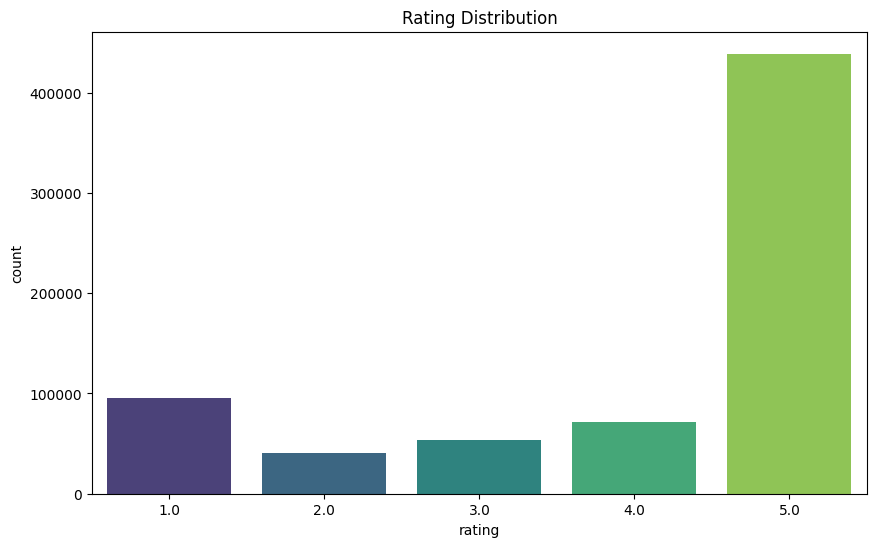

In [ ]:

import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Rating Distribution')
plt.show()



### 价格分布

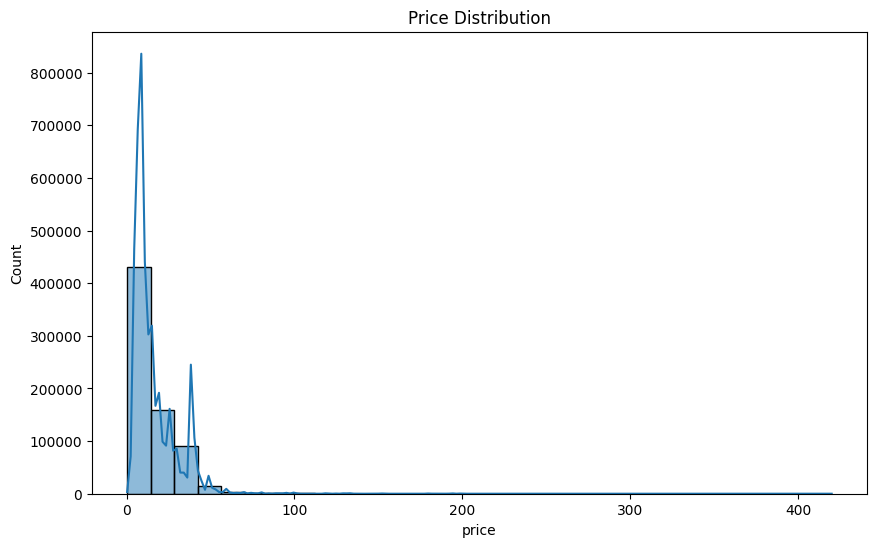

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.show()

### 品牌占比

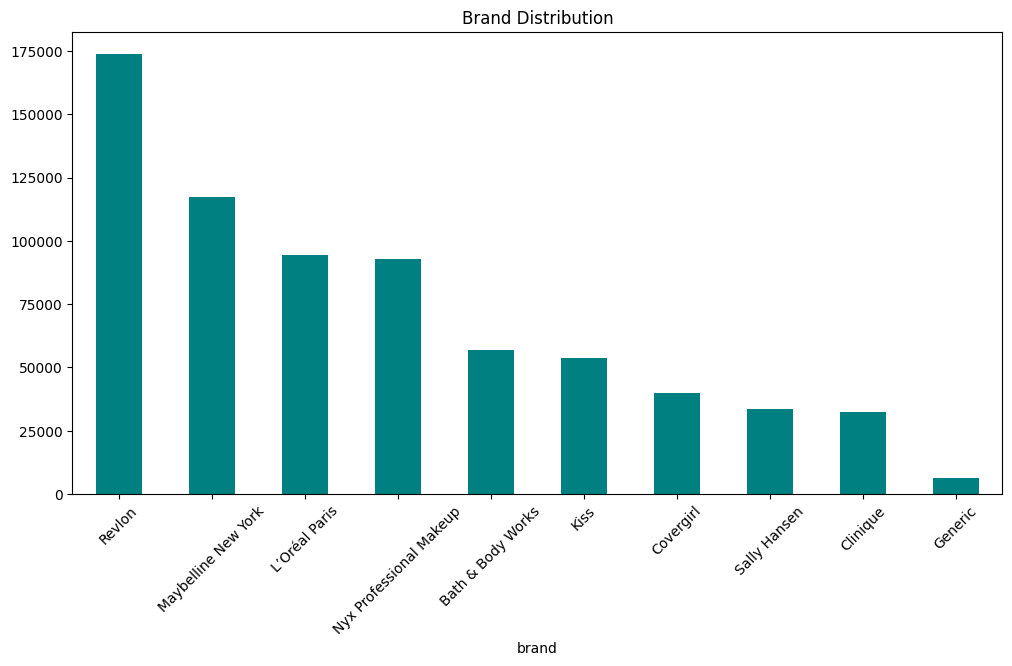

In [ ]:
plt.figure(figsize=(12,6))
df['brand'].value_counts().plot(kind='bar', color='teal')
plt.title('Brand Distribution')
plt.xticks(rotation=45)
plt.show()

  ## 5. 情感分析
  ### 情感分布


In [ ]:
# 文本预处理

def text_preprocessing(text):
    # 小写转换
    text = text.lower()
    # 移除特殊字符和数字
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # 分词
    tokens = nltk.word_tokenize(text)
    # 移除停用词
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # 词形还原
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)


In [ ]:
# 应用预处理4分钟5分钟
df['cleaned_text'] = df['text'].apply(text_preprocessing)

In [ ]:
 #情感标签生成
# ====================
# 二分类标签（1=正面，0=负面）
df['sentiment'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0 if x <= 2 else np.nan)
df.dropna(subset=['sentiment'], inplace=True)


In [ ]:
# 查看分布
print("\n情感分布:")
print(df['sentiment'].value_counts())



情感分布:
sentiment
1.0    510871
0.0    136101
Name: count, dtype: int64


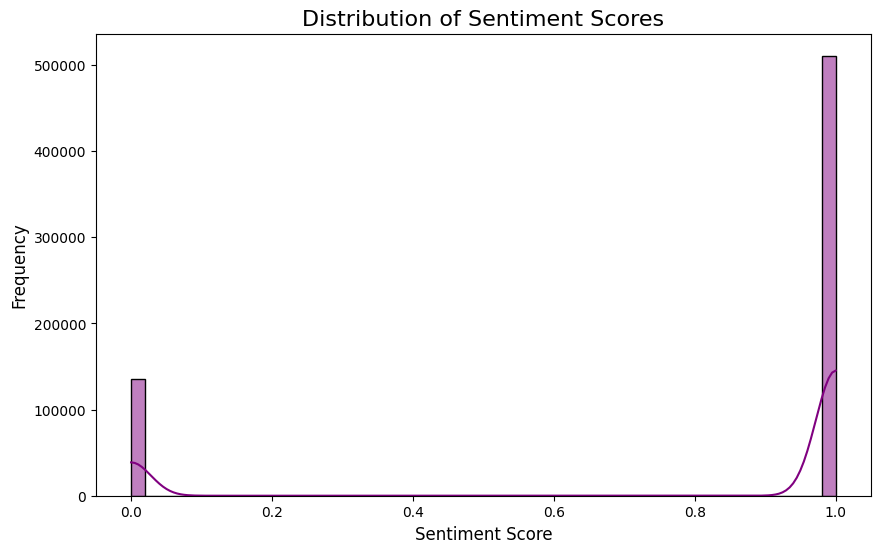

In [ ]:
# Plot sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], kde=True, bins=50, color='purple')
plt.title('Distribution of Sentiment Scores', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('sentiment_distribution.png', dpi=300, bbox_inches='tight')

### 数据平衡处理（SMOTE）

In [ ]:

# 文本向量化
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['cleaned_text'])
y = df['sentiment']

In [ ]:
# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
# 应用SMOTE7分钟
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


## 6. 模型对比
### 机器学习模型的训练与评估

In [ ]:



def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{type(model).__name__} 性能:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    print(classification_report(y_test, y_pred))

    # 混淆矩阵可视化
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{type(model).__name__} Confusion Matrix')
    plt.show()



正在训练 Logistic Regression

LogisticRegression 性能:
Accuracy: 0.8858070250009661
ROC AUC: 0.9507849364492746
              precision    recall  f1-score   support

         0.0       0.68      0.87      0.76     27220
         1.0       0.96      0.89      0.92    102175

    accuracy                           0.89    129395
   macro avg       0.82      0.88      0.84    129395
weighted avg       0.90      0.89      0.89    129395



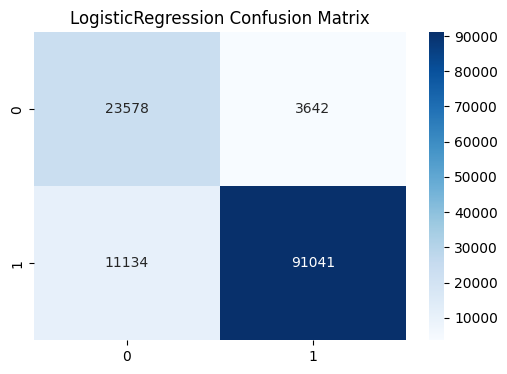


正在训练 Random Forest

RandomForestClassifier 性能:
Accuracy: 0.8156111132578538
ROC AUC: 0.8943442387441265
              precision    recall  f1-score   support

         0.0       0.54      0.79      0.64     27220
         1.0       0.94      0.82      0.88    102175

    accuracy                           0.82    129395
   macro avg       0.74      0.81      0.76    129395
weighted avg       0.85      0.82      0.83    129395



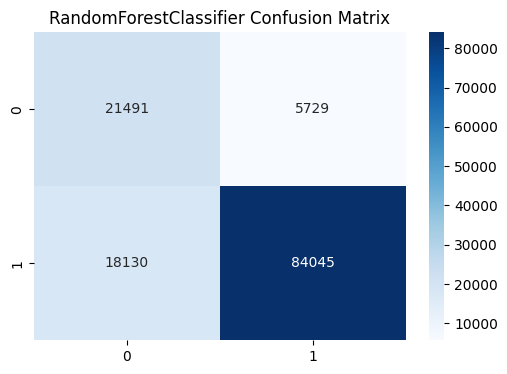

In [ ]:
# 初始化模型1min
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Random Forest": RandomForestClassifier(  # 保持键名不变（如果其他代码依赖名称）
        n_estimators=50,
        max_depth=15,
        max_samples=0.5,
        n_jobs=-1,
        class_weight='balanced',
        random_state=42
    )
}

# 训练并评估
for name, model in models.items():
    print("\n" + "="*50)
    print(f"正在训练 {name}")
    train_evaluate_model(model, X_train_bal, y_train_bal, X_test, y_test)


### VADER情感分析

In [ ]:
!pip install vaderSentiment



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00


In [ ]:
# VADER情感分析基准

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    return 1 if score >= 0.05 else 0 if score <= -0.05 else np.nan


In [ ]:
# 预测并评估2min
df['vader_pred'] = df['text'].apply(vader_sentiment)
df_vader = df.dropna(subset=['vader_pred'])

print("\nVADER 性能:")
print("Accuracy:", accuracy_score(df_vader['sentiment'], df_vader['vader_pred']))
print(classification_report(df_vader['sentiment'], df_vader['vader_pred']))



VADER 性能:
Accuracy: 0.8878272771424787
              precision    recall  f1-score   support

         0.0       0.77      0.59      0.67    108197
         1.0       0.91      0.96      0.93    458028

    accuracy                           0.89    566225
   macro avg       0.84      0.77      0.80    566225
weighted avg       0.88      0.89      0.88    566225



## 7. 特征影响分析
###  品牌平均情感

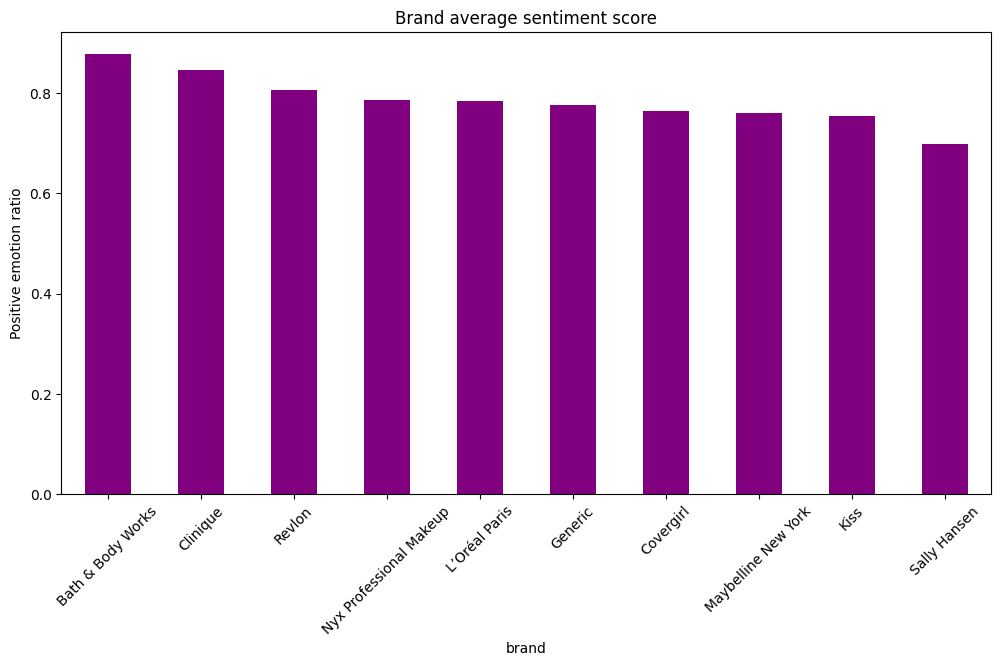

In [ ]:


brand_sentiment = df.groupby('brand')['sentiment'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
brand_sentiment.plot(kind='bar', color='purple')
plt.title('Brand average sentiment score')
plt.ylabel('Positive emotion ratio')
plt.xticks(rotation=45)
plt.show()

### 价格与情感关系

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from font(s) DejaVu Sans.
  fig.canvas

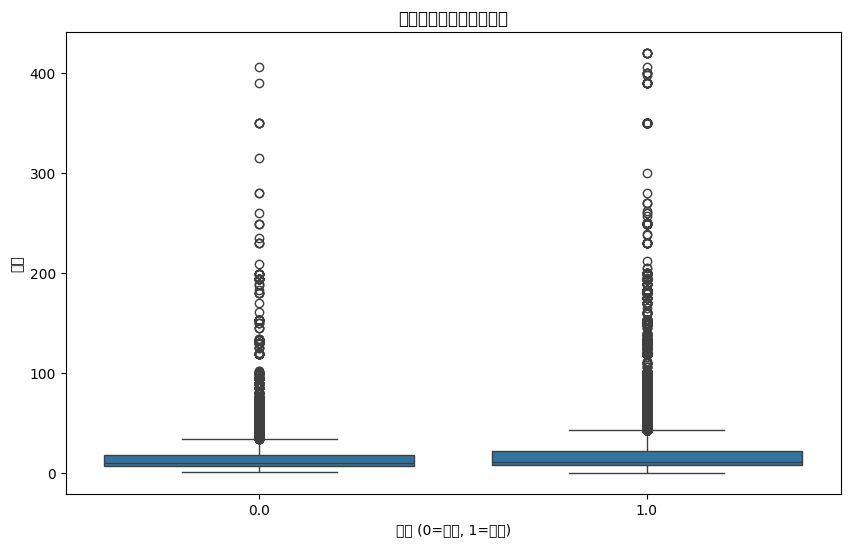

In [ ]:

plt.figure(figsize=(10,6))
sns.boxplot(x='sentiment', y='price', data=df)
plt.title('价格在不同情感中的分布')
plt.xlabel('情感 (0=负面, 1=正面)')
plt.ylabel('价格')
plt.show()

### 颜色负面情感分析



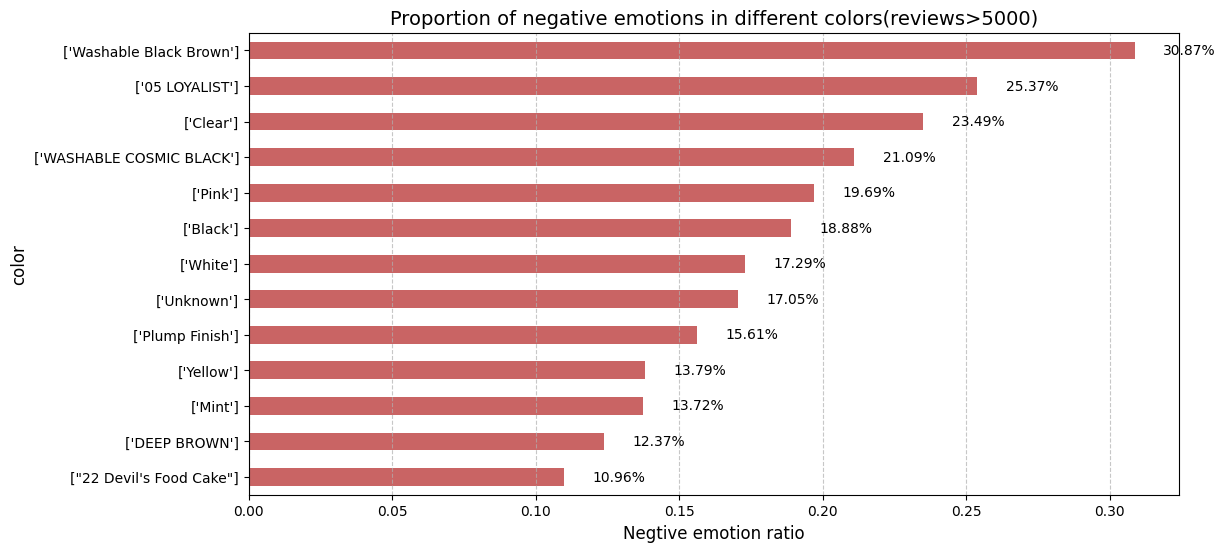

In [ ]:

# 计算每个颜色的负面情感比例（sentiment=0的均值）
color_negative = df.groupby('color')['sentiment'].apply(lambda x: (x == 0).mean())

# 过滤至少50条评论的颜色（确保统计显著性）
color_counts = df['color'].value_counts()
valid_colors = color_counts[color_counts >= 5000].index
color_negative = color_negative[color_negative.index.isin(valid_colors)].sort_values()

# 可视化
plt.figure(figsize=(12,6))
color_negative.plot(kind='barh', color='firebrick', alpha=0.7)  # 使用暗红色表示负面
plt.title('Proportion of negative emotions in different colors(reviews>5000)', fontsize=14)
plt.xlabel('Negtive emotion ratio', fontsize=12)
plt.ylabel('color', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 添加数值标签
for i, v in enumerate(color_negative):
    plt.text(v + 0.01, i, f"{v:.2%}", ha='left', va='center', fontsize=10)

plt.show()

### 价格区间与品牌的交互

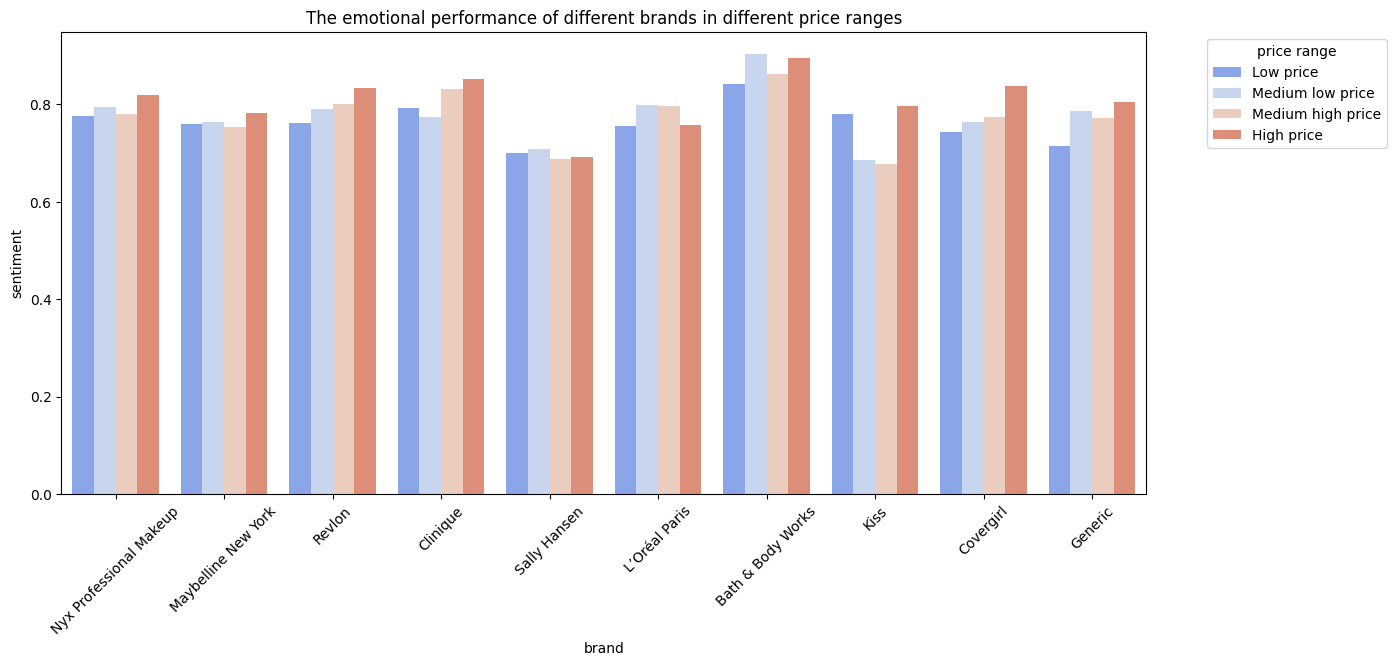

In [ ]:

df['price_bin'] = pd.qcut(df['price'], q=4, labels=['Low price', 'Medium low price', 'Medium high price', 'High price'])

plt.figure(figsize=(14,6))
sns.barplot(
    x='brand',
    y='sentiment',
    hue='price_bin',
    data=df,
    palette='coolwarm',
    errorbar=None
)
plt.title('The emotional performance of different brands in different price ranges')
plt.xticks(rotation=45)
plt.legend(title='price range', bbox_to_anchor=(1.05, 1))
plt.show()


## 8. 可视化：词云生成

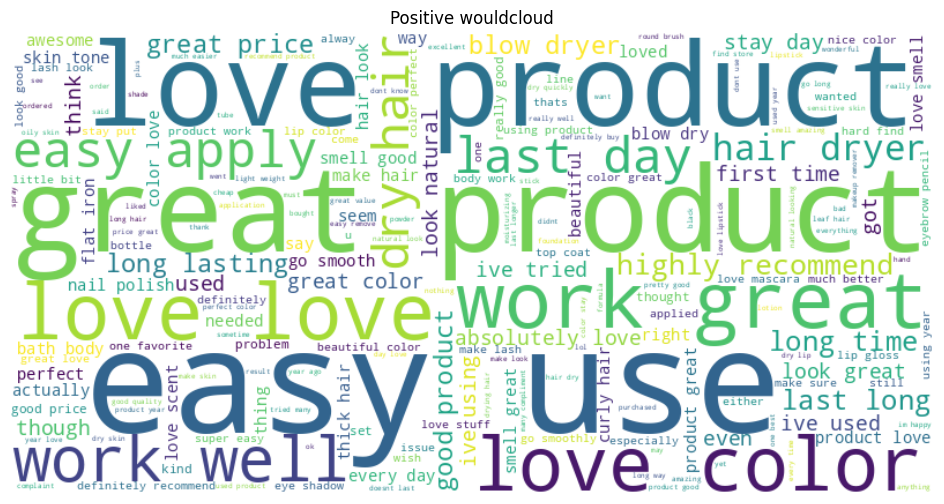

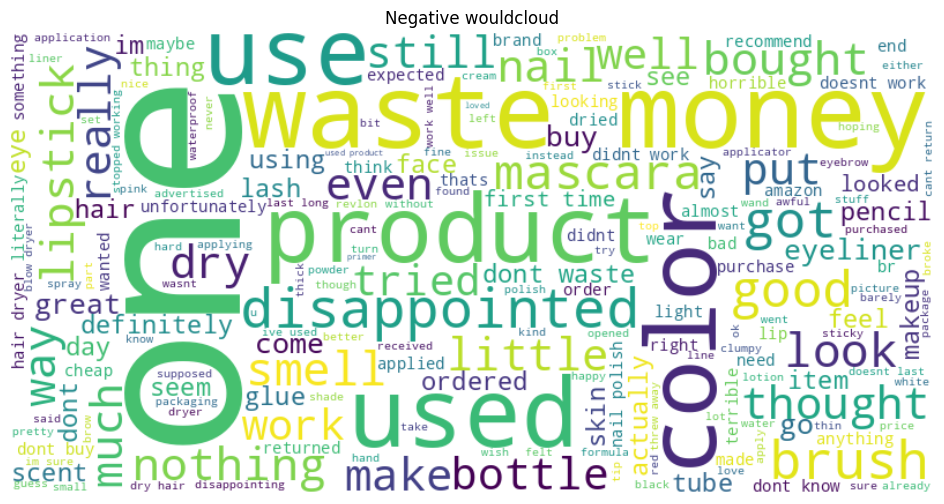

In [ ]:

def generate_wordcloud(sentiment):
    text = ' '.join(df[df['sentiment'] == sentiment]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{"Positive" if sentiment == 1 else "Negative"} wouldcloud')
    plt.show()

generate_wordcloud(1)  # 正面词云
generate_wordcloud(0)  # 负面词云


In [ ]:
# 高频关键词分析
from collections import Counter


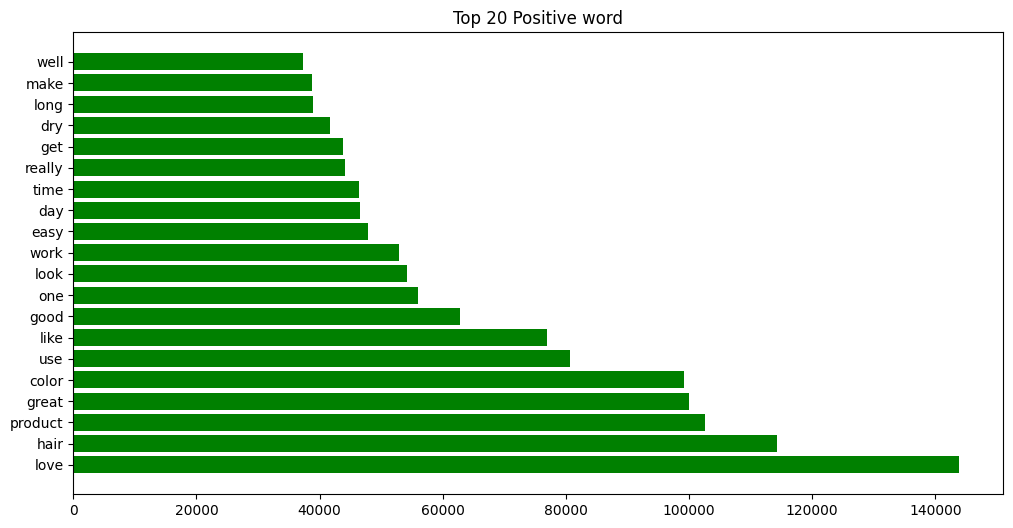

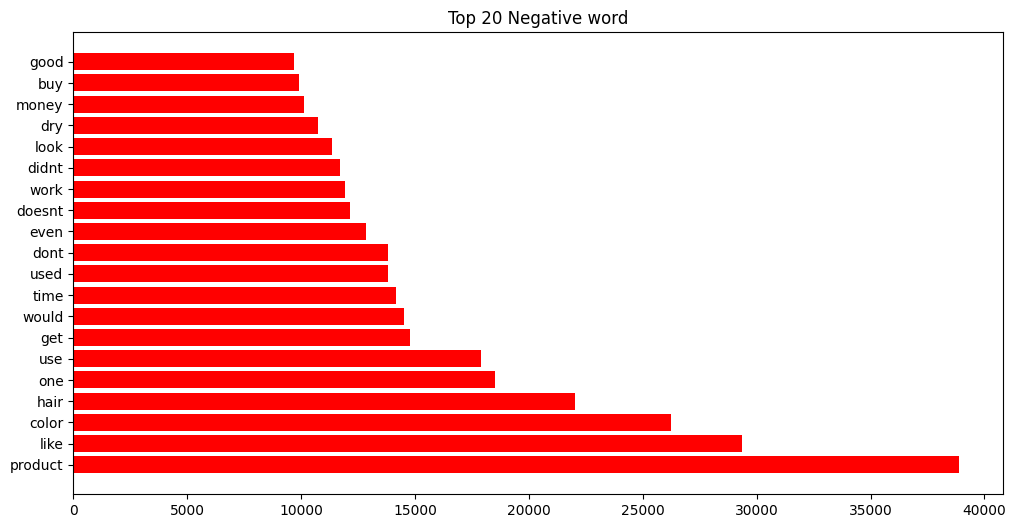

In [ ]:
# 提取正面关键词
positive_words = ' '.join(df[df['sentiment'] == 1]['cleaned_text']).split()
positive_counts = Counter(positive_words).most_common(20)

# 提取负面关键词
negative_words = ' '.join(df[df['sentiment'] == 0]['cleaned_text']).split()
negative_counts = Counter(negative_words).most_common(20)

# 可视化
plt.figure(figsize=(12,6))
plt.barh([w[0] for w in positive_counts[:20]], [w[1] for w in positive_counts[:20]], color='green')
plt.title('Top 20 Positive word')
plt.show()

plt.figure(figsize=(12,6))
plt.barh([w[0] for w in negative_counts[:20]], [w[1] for w in negative_counts[:20]], color='red')
plt.title('Top 20 Negative word')
plt.show()